# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

### I have read and understood the instructions: 305494452_309797827

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution)) 
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

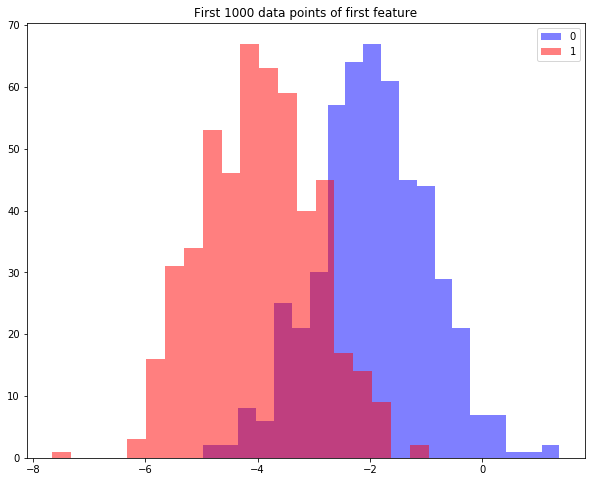

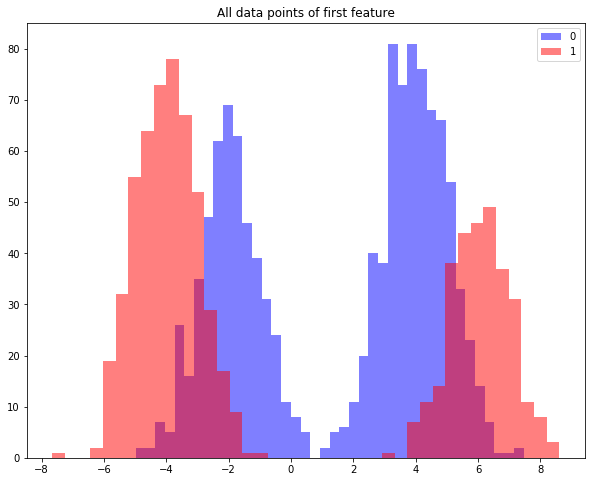

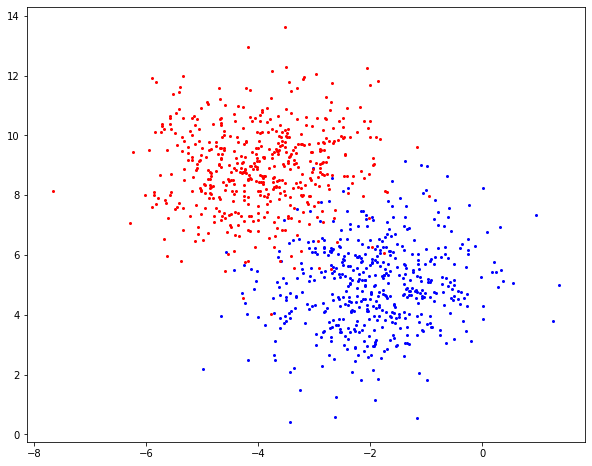

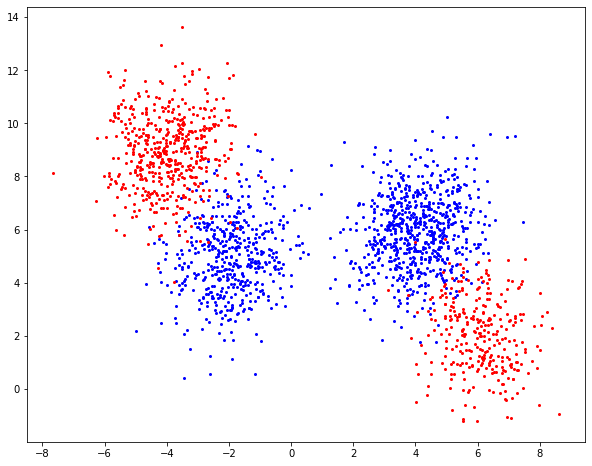

In [4]:
numOFBinsFirstHistogram=20
numOFBinsSecondHistogram=40
numOfDataPoints=1000
histogramAlpha=0.5

DataPointsX1=training_set[['x1','y']].values
DataPointsX2=training_set[['x2','y']].values
partiallyThousandDataPoints=training_set.head(numOfDataPoints)
thousandDataPointsX1=partiallyThousandDataPoints[['x1','y']].values
thousandDataPointsX2=partiallyThousandDataPoints[['x2','y']].values

plt.hist([thousandDataPointsX1[thousandDataPointsX1[:,-1]==0][:,0]],numOFBinsFirstHistogram,facecolor='blue',alpha=histogramAlpha,label = 0)
plt.hist([thousandDataPointsX1[thousandDataPointsX1[:,-1]==1][:,0]],numOFBinsFirstHistogram,facecolor='red',alpha=histogramAlpha, label = 1)
plt.legend()
plt.title("First 1000 data points of first feature")
plt.show()

plt.hist([DataPointsX1[DataPointsX1[:,-1]==0][:,0]],numOFBinsSecondHistogram,facecolor='blue',alpha=histogramAlpha,label = 0)
plt.hist([DataPointsX1[DataPointsX1[:,-1]==1][:,0]],numOFBinsSecondHistogram,facecolor='red',alpha=histogramAlpha,label = 1)
plt.legend()
plt.title("All data points of first feature")
plt.show()

plt.scatter([thousandDataPointsX1[thousandDataPointsX1[:,-1]==0][:,0]],[thousandDataPointsX2[thousandDataPointsX2[:,-1]==0][:,0]], color = 'blue',s = 4)
plt.scatter([thousandDataPointsX1[thousandDataPointsX1[:,-1]==1][:,0]],[thousandDataPointsX2[thousandDataPointsX2[:,-1]==1][:,0]], color = 'red',s = 4)
plt.show()

plt.scatter([DataPointsX1[DataPointsX1[:,-1]==0][:,0]],[DataPointsX2[DataPointsX2[:,-1]==0][:,0]], color = 'blue',s = 4)
plt.scatter([DataPointsX1[DataPointsX1[:,-1]==1][:,0]],[DataPointsX2[DataPointsX2[:,-1]==1][:,0]], color = 'red',s = 4)
plt.show()

## Logistic Regression

(20 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [5]:
# Add Bias
npArrayXValofOnes = np.ones(len(X_training[:,0]))
X_trainingWithBias = np.column_stack((npArrayXValofOnes, X_training))
npArrayXValofOnesTest = np.ones(len(X_test[:,0]))
X_testgWithBias = np.column_stack((npArrayXValofOnesTest, X_test))

In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.costList = []
        self.theta=None
        np.random.seed(self.random_state)
   
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        
        self.theta = np.random.random(size = len(X[0,:]))
        self.costList.append(self.calculateAverageCostFunction(X,y))
        for i in  range (1,self.n_iter):
            gradient = np.dot(X.T, (self.getHFunction(X) - y)) 
            self.theta =  self.theta - self.eta * gradient
            self.costList.append(self.calculateAverageCostFunction(X,y))
            if ((len(self.costList) > 1) and (np.abs(self.costList[-2] - self.costList[-1]) < self.eps)):
                break
   
    def predict(self, X):
        """Return the predicted class label""" 
        if((len(X[0,:])!=(len(self.theta)))):
            npArrayXValofOnes = np.ones(len(X[:,0]))
            XToSend = np.column_stack((npArrayXValofOnes, X))
            return np.rint(self.getHFunction(XToSend)) 
        return np.rint(self.getHFunction(X))  
    
    def calcAccuracy(self,X,y):
        npPred = self.predict(X)
        sum = 0.0
        for i in range(0,len(y)):
            if npPred[i]==y[i]:
                sum = sum + 1
        return sum / len(y)    
    
    def calculateAverageCostFunction(self, X, y):
        return (-y * np.log(self.getHFunction(X)) - (1 - y) * np.log(1 - self.getHFunction(X))).mean()        
        
    def getHFunction (self,X):
        return 1 / (1 + np.exp(-np.dot(X, self.theta)))

## Cross Validation

(10 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [7]:
# Initialize 
np.random.seed(1)
etas = [ 0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
gapAmount = 5
mesh = np.array(np.meshgrid(etas, epss))
#All Hyperparamter combinations
combinations = mesh.T.reshape(-1, 2)
combainData=np.column_stack((X_trainingWithBias, y_training))
np.take(combainData,np.random.permutation(combainData.shape[0]),axis = 0,out = combainData)

# After shuffle
X_trainingWithBiasForCross=combainData[:, 0:-1]
y_trainingForCross=combainData[:,-1]
crossGap = int(len(X_training[:,0]) / gapAmount)
bestHyperParmater = None
maxAccuricy = None
# Check all hyperparamters
for hyperParamterCombination in combinations:
    startIndex = 0
    allHyperParamterAccuricy = 0
    logicreg = LogisticRegressionGD(hyperParamterCombination[0],10000,hyperParamterCombination[1])
    # Split for Validation and traning
    for i in range(0,gapAmount - 1):
        xCrossValdition = X_trainingWithBiasForCross[startIndex:(startIndex + crossGap),:]
        yCrossValdition = y_trainingForCross[startIndex:(startIndex + crossGap)]
        xNewTraining = np.concatenate((X_trainingWithBiasForCross[:startIndex,:], X_trainingWithBiasForCross[(startIndex + crossGap):,:]), axis=0)
        yNewTraining = np.concatenate((y_trainingForCross[:startIndex], y_trainingForCross[(startIndex + crossGap):]), axis = 0)
        startIndex += crossGap
        logicreg.fit(xNewTraining,yNewTraining)
        currentAccury = logicreg.calcAccuracy(xCrossValdition,yCrossValdition)
        allHyperParamterAccuricy = allHyperParamterAccuricy + currentAccury    
    # The last partition for split
    xCrossValdition = X_trainingWithBiasForCross[startIndex:,:]
    yCrossValdition = y_trainingForCross[startIndex:]
    xNewTraining = X_trainingWithBiasForCross[:startIndex,:]
    yNewTraining = y_trainingForCross[:startIndex]    
    logicreg.fit(xNewTraining,yNewTraining)
    currentAccury = logicreg.calcAccuracy(xCrossValdition,yCrossValdition)
    allHyperParamterAccuricy = allHyperParamterAccuricy + currentAccury
    # Calculate the average accuracy
    allHyperParamterAccuricy = allHyperParamterAccuricy / gapAmount
    # Change hyperparamter iff it have better accuracy
    if bestHyperParmater is None:
        bestHyperParmater=hyperParamterCombination
        maxAccuricy=allHyperParamterAccuricy
    elif maxAccuricy<allHyperParamterAccuricy:
        bestHyperParmater=hyperParamterCombination
        maxAccuricy=allHyperParamterAccuricy
print("Best HyperParamter: " + str(bestHyperParmater))

Best HyperParamter: [5.e-05 1.e-06]


## Normal distribution pdf

(5 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [8]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    deltaSquare=sigma **(2)
    fractionWithRoot=1 / ((2 * np.pi*deltaSquare)**(1 / 2))
    eAndPower=np.exp(-1 * (((data - mu)**2)) / (2 * deltaSquare))
    return fractionWithRoot * eAndPower    

## Expectation Maximization

(20 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [9]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.npResponsibilitiesTable=None
        self.npArrayMu=None
        self.npArraySigma=None
        self.npArrayW=None
        

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        # 
        sortedData=np.sort(data)
        self.npResponsibilitiesTable = np.zeros(shape=(len(data[:]),self.k))
        self.npArrayMu = np.zeros(self.k)
        self.npArraySigma = np.zeros(self.k)
        self.npArrayW = np.zeros(self.k)
        self.npResponsibilitiesTable=self.npResponsibilitiesTable.astype(np.float)
        self.npArraySigma=self.npArraySigma.astype(np.float)
        self.npArrayMu=self.npArrayMu.astype(np.float)
        self.npArrayW=self.npArrayW.astype(np.float)
        np.random.seed(42)
        crossGap =(int)((len(data[:])) / self.k)
        startIndex = 0
        sortedData=np.sort(data[:])
        for i in range(0,self.k):
            if i == self.k - 1:
                xKData = sortedData[startIndex:]
            else:
                xKData = sortedData[startIndex:(startIndex + crossGap)]
            startIndex += crossGap
            self.npArrayMu[i] = xKData.mean()
            self.npArraySigma[i] = ((np.sum((xKData[:] - self.npArrayMu[i])**2))/(len(xKData[:])))**(1/2)   
            self.npArrayW[i] = 1.0 / self.k
       
            
           
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        for row in range (len(data[:])):
            for k in range (self.k):
                self.npResponsibilitiesTable[row, k] = self.npArrayW[k] * norm_pdf(data[row],self.npArrayMu[k], self.npArraySigma[k]) 
            self.npResponsibilitiesTable[row] = self.npResponsibilitiesTable[row] / np.sum( self.npResponsibilitiesTable[row])

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        numOfRows = (1/len(data[:]))
        weightsToInsert = numOfRows * np.sum(self.npResponsibilitiesTable, axis=0)
        for k in range(self.k):
            self.npArrayW[k] = weightsToInsert[k]
            sumToAdd = np.sum((self.npResponsibilitiesTable[:,k] * data))
            self.npArrayMu[k] = (numOfRows / self.npArrayW[k]) * sumToAdd
            sumToAdd = np.sum((self.npResponsibilitiesTable[:,k] * (data-self.npArrayMu[k])**2))
            self.npArraySigma[k] = np.sqrt((numOfRows / self.npArrayW[k]) * sumToAdd)
                                                                        
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        
        currentCostFunction = 0.0
        previousCostFunction = None
        for i in range(0,self.n_iter):
            self.expectation(data)
            self.maximization(data)
            currentCostFunction = self.costfunction(data)
            if((previousCostFunction is not None) and (np.abs(currentCostFunction - previousCostFunction) < self.eps)):
                break
            previousCostFunction = currentCostFunction           
            
    def get_dist_params(self):
        return self.npArrayMu, self.npArraySigma, self.npArrayW
    
    def pdfMixture(self,x):
        numOfGuusian = len(self.npArraySigma)
        mixtureProb = 0
        for i in range (0, numOfGuusian):
            mixtureProb = mixtureProb + self.npArrayW[i] * norm_pdf(x,self.npArrayMu[i],self.npArraySigma[i])
        return mixtureProb
    
    def costfunction(self, data):
        allSum = 0.0
        sigma = 0.0
        for currentInstance in range(0, len(data[:,])):
            for currentGausian in range(0,self.k):
                sigma = sigma + self.npArrayW[currentGausian] * norm_pdf(data[currentInstance], self.npArrayMu[currentGausian],  self.npArraySigma[currentGausian])
            allSum = allSum - np.log(sigma) 
            sigma = 0.0
        return allSum

## Naive Bayes

(20 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [10]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.npMuArray=None
        self.npSigmaArray=None   
        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """       
       
        self.priorLabel_0=len(y[:]==0)/ len(y[:])        
        self.priorLabel_1=len(y[:]==1) / len(y[:])  
        self.npEM = np.empty((len(y[:]),2), dtype=object)
        combainDataAll=np.column_stack((X, y))
                
        for labelIndex in range(0,2):
            combainData=combainDataAll[combainDataAll[:,-1]==labelIndex]           
            for featureIndex in range(0,len(X[0,:])):                
                dataToSendCrop = combainData[:,featureIndex]
                currentEM = EM(2)
                currentEM.init_params(dataToSendCrop)                
                currentEM.fit(dataToSendCrop)
                self.npEM[featureIndex,labelIndex] = currentEM                        
                                 
    def predict(self, X):
        """Return the predicted class label"""
        npArray = np.zeros(len(X[:,0]))
        for i in range(0,len(X[:,0])):
            zeroPosterior =  self.priorLabel_0 *  self.npEM[0,0].pdfMixture(X[i,0]) * self.npEM[1,0].pdfMixture(X[i,1])
            onePosterior =  self.priorLabel_1 *  self.npEM[0,1].pdfMixture(X[i,0]) * self.npEM[1,1].pdfMixture(X[i,1])
            if(zeroPosterior <= onePosterior):
                npArray[i]=1
            else:
                npArray[i]=0 
        return npArray
                
    def calcAccuracy(self,X,y):
        npPred = self.predict(X)
        sum = 0.0
        for i in range(0,len(y[:])):
            if npPred[i] == y[i]:
                sum = sum + 1
        return sum / len(y[:])

## Model evaluation

(10 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points

On partially data:
Logistic Regression on training data:
0.965

Naivebase on training data:
0.968

Logistic Regression on test data:
0.938

Naivebase on test data:
0.942


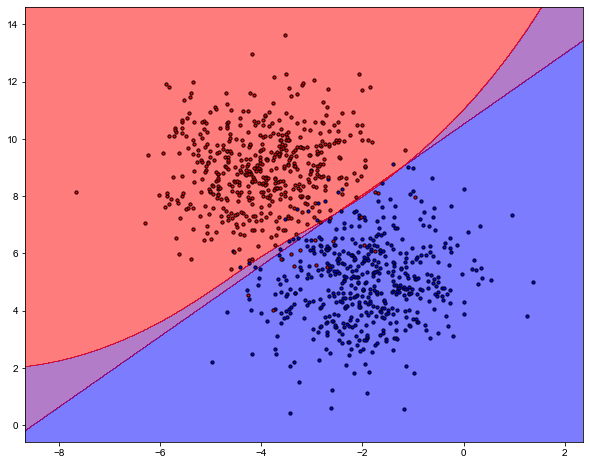

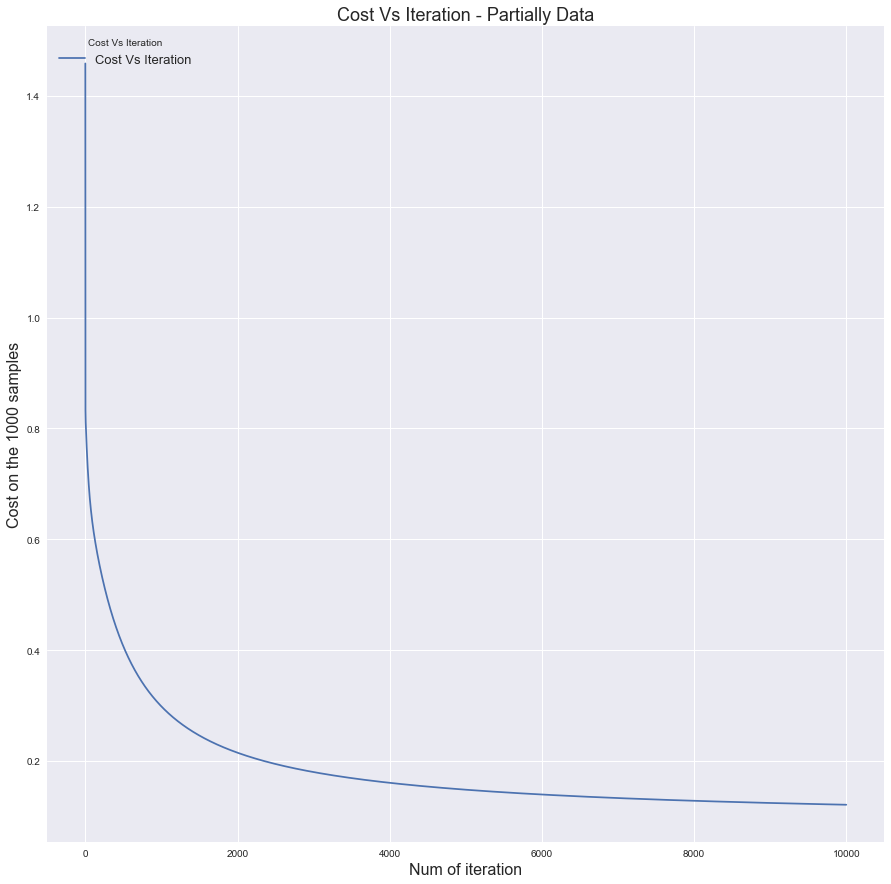

In [11]:
numOFBinsFirstHistogram=20
numOFBinsSecondHistogram=40
numOfDataPointsTraining=1000
numOfDataPointsTest=500
histogramAlpha=0.5
bestLogisticRegressionEta= bestHyperParmater[0]
bestLogisticRegressionEps= bestHyperParmater[1]

# Logistic Regression on training data
logisticRegressionOnPartiallyData = LogisticRegressionGD(bestLogisticRegressionEta,10000,bestLogisticRegressionEps)
logisticRegressionOnPartiallyData.fit(X_trainingWithBias[:1000,],y_training[:1000,])


# Naivebase on training data
naivebaseOnPartiallyData = NaiveBayesGaussian()
naivebaseOnPartiallyData.fit(X_training[:1000,],y_training[:1000,])

print("On partially data:")
print("Logistic Regression on training data:")
print(logisticRegressionOnPartiallyData.calcAccuracy(X_trainingWithBias[:1000,],y_training[:1000]))
print()
print("Naivebase on training data:")
print(naivebaseOnPartiallyData.calcAccuracy(X_training[:1000,],y_training[:1000]))
print()
print("Logistic Regression on test data:")
print(logisticRegressionOnPartiallyData.calcAccuracy(X_testgWithBias[:500,],y_test[:500]))
print()
print("Naivebase on test data:")
print(naivebaseOnPartiallyData.calcAccuracy(X_test[:500,],y_test[:500]))

plot_decision_regions(X_training[:1000,:], y_training[:1000], classifier=logisticRegressionOnPartiallyData)
plot_decision_regions(X_training[:1000,:] ,y_training[:1000], classifier=naivebaseOnPartiallyData)


############# plot cost VS iteration ###########
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,15))

npCostArray = logisticRegressionOnPartiallyData.costList
npNumOfIterationArray=np.arange(len(npCostArray))

plt.plot(np.arange(0,len(npNumOfIterationArray)),npCostArray,label='Cost Vs Iteration')
plt.xlabel('Num of iteration',fontsize='16')
plt.ylabel('Cost on the 1000 samples',fontsize='16')
plt.legend(loc='upper left',fontsize='13',title='Cost Vs Iteration')
plt.title ('Cost Vs Iteration - Partially Data', fontsize = '18')
plt.show()   


On all data:
Logistic Regression on all training data:
0.809

Naivebase on all training data:
0.9195

Logistic Regression on all test data:
0.804

Naivebase on all test data:
0.902


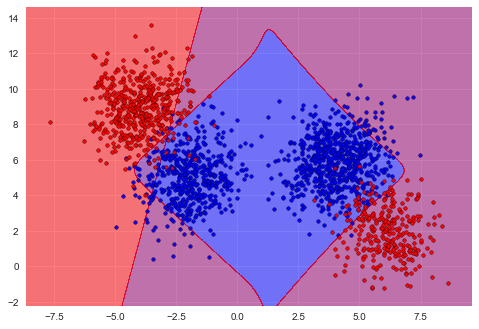

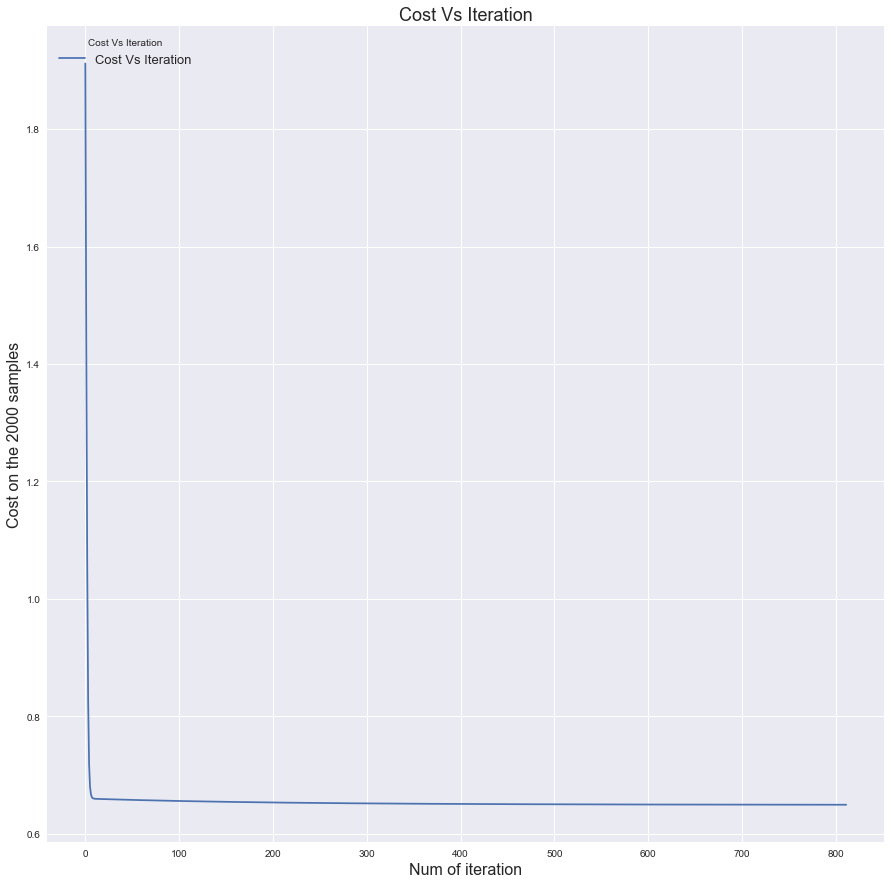

In [12]:
# Logistic Regression on training data
logisticRegressionAll = LogisticRegressionGD(bestLogisticRegressionEta,10000,bestLogisticRegressionEps)
logisticRegressionAll.fit(X_trainingWithBias,y_training)

# Naivebase on training data
naivebaseAll = NaiveBayesGaussian()
naivebaseAll.fit(X_training,y_training)

print("On all data:")
print("Logistic Regression on all training data:")
print(logisticRegressionAll.calcAccuracy(X_trainingWithBias,y_training))
print()
print("Naivebase on all training data:")
print(naivebaseAll.calcAccuracy(X_training,y_training))
print()
print("Logistic Regression on all test data:")
print(logisticRegressionAll.calcAccuracy(X_testgWithBias,y_test))
print()
print("Naivebase on all test data:")
print(naivebaseAll.calcAccuracy(X_test,y_test))

plot_decision_regions(X_training, y_training, classifier=logisticRegressionAll)
plot_decision_regions(X_training ,y_training, classifier=naivebaseAll)

############# plot cost VS iteration ###########
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,15))

npCostArray = logisticRegressionAll.costList
npNumOfIterationArray=np.arange(len(npCostArray))

plt.plot(np.arange(0,len(npNumOfIterationArray)),npCostArray,label='Cost Vs Iteration')
plt.xlabel('Num of iteration',fontsize='16')
plt.ylabel('Cost on the 2000 samples',fontsize='16')
plt.legend(loc='upper left',fontsize='13',title='Cost Vs Iteration')
plt.title ('Cost Vs Iteration', fontsize = '18')
plt.show()


## Open question

(7 points) 

Will Full Bayes get better results comparing to Naive Bayes on the following dataset? Explain. 

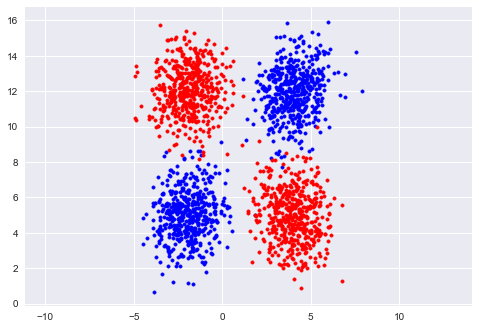

In [13]:
mean = [[-2,5], [-2, 12], [4, 12], [4, 5]]
cov = [[[1,0.2],[0.2,2]], [[1,0],[0,2]], [[1,0.2],[0.2,2]], [[1,-0.2],[-0.2,2]]]
x1 = []
x2 = []
y = []
size = [500, 500, 500, 500]
c = ['b', 'r']
for i in range(4):
    xx1,xx2 = np.random.multivariate_normal(mean[i],cov[i],size[i]).T
    x1.extend(xx1)
    x2.extend(xx2)
    y.extend([i%2] * size[i])
    plt.scatter(xx1,xx2, marker='.', c=c[i%2])
plt.axis('equal')
plt.show()

#### Your answer here ####


In [ ]:
:הטענה נכונה כלומר אלגוריתם פול בייס יציג תוצאות טובות יותר מאלגוריתם בייס הנאיבי בעבור הדטה סט הבא, ונסביר מדוע
על מנת, שנאיב בייס יהיה מדויק באותה מידה כמו הפול בייס יש צורך להניח אי תלות בהינתן הקלאס
בלי הגבלת הכלליות נביא בנקודות הכחולות השייכות לקלאס הכחול, ניתן לשים כי קיים מתאם חיובי לא מושלם בין הנקודות הכחולות.
כאשר נגדיל את ערכי ציר האיקס ערכי ציר הויי יגדלו גם כן ולהפך.
אזי השונות המשותפת בהכרח שונה מאפס כלומר קיימת תלות בין ציר האיקס שמהווה פיצר מסויים לציר הויי שמהווה פיצר אחר
כלומר ההנחה של אי התלות הנאיב בייס לא מתקיימת ולכן עדיף להשתמש בפול בייס